# Perform a looping with a quadrotor

# Goal of the project

The goal of this project is to control a 2D quadrotor to get it to perform acrobatic moves. The controller will be designed using an SQP solver.

Please submit your code as a runnable Jupyter Notebook.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vempccal positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inempca (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [1]:
import quadrotor

print("Mass    =", quadrotor.MASS)
print("Length  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)

Mass    = 0.45
Length  = 0.14
Inertia = 0.09
Dt      = 0.04
state size   = 6
control size = 2




## Part 1 - Setting up the trajectory optimization problem (50 points)
1. Discretize the system dynamics using Euler's method seen in class - write the time discretization step as $\Delta t$ (use symbols not numbers for the mass, etc)
2. We would like the quadrotor to perfom a looping (i.e. a back or front flip). Find and implement a suitable cost function to perform a looping and add constraints to maintain the thrust of each rotor between $0$ and $10$. Solve the problem using your own implementation of a SQP with a long horizon to ensure that you can do a looping.
3. Show plots of all the states and controls of the robot as a function of time. Plot the value of $\alpha$ (during line search) at each iteration of the solver as well as the amount of constraint violation per iteration and the cost per iteration of the solver (also useful to help you debug).
5. Describe your design choices (in a concise manner) in the report.

To visualize the trajectory, use the ```quadrotor.animate_robot``` function and show the animation (show the plots in your report).

### Tips to implement a SQP solver
1. Write down the algorithm (in words not in code), i.e. write all the steps you need to take
2. Write the gradient of the running cost at a given guess $\bar{x} = [{\bar{p}_x}_0, {\bar{v}_x}_0, {\bar{p}_y}_0, {\bar{v}_{y}}_0, \bar{\theta}_0, \bar{\omega}_0, {\bar{u}_1}_0, {\bar{u}_2}_0, \dots, {\bar{p}_x}_N, {\bar{v}_x}_N, {\bar{p}_y}_N, {\bar{v}_{y}}_N, \bar{\theta}_N, \bar{\omega}_N, {\bar{u}_1}_N, {\bar{u}_2}_N,]^T$, i.e. for a given value of these variables and implement a function that computes it
3. Write the Hessian of the running cost at a given guess $\bar{x}$ and implement a function that computes it
4. Assume that the Hessian of the constraints is 0 (i.e. ignore the second order derivatives of the constraints)
5. Write a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ (don't forget the constant terms in g) where $\Delta x$ represents a small variation around $\bar{x}$ and implement a function that computes both $G$ and $g$.
6. Use these functions to setup the inner QP of the SQP (use the library from HW2 to solve the QP).
7. Implement a function that computes the amount of constraint violation for the nonlinear constraints (not the linearized one), i.e. the sum of the absolute values of all the constraints (i.e. assuming constraints of the form $c(x) = 0$ we want to compute $|c(x)|$).
8. Implement a filter linear search to test if a step should be accepted. You will implement the (simplified) filter line search explained below.
9. Terminate the algorithm when you either reached the maximum number of iterations (e.g. 100) or when the KKT optimality conditions are satisfied (within a small margin, e.g. $10^{-4}$).

Once you have a solution, make sure to check that it satisfies the constraints! You can display the robot using the ```animate_robot``` function.

#### (Simple) filter linear search
Once you have a potential step $\textrm{step}_x$, you need to find a step $\alpha$ to update your guess of the solution $x_{guess}$. We will accept a step that either reduces the amount of constraint violation or reduces the cost.

Let's denote $f(x)$ the cost at $x$ and $|c(x)|$ the amount of constraint violation at $x$. Initialize the variable $f_{best} = \infty$ and $c_{best}=\infty$ at the beginning of the SQP. 

Then do the following during the line search.
1. Set $\rho$ to a number between 0 and 1 (e.g. 0.5) and set $\alpha = 1$
2. If $f(x_{guess} + \alpha \textrm{step}_x) < f_{best}$ then set $f_{best} \leftarrow f(x_{guess} + \alpha \textrm{step}_x)$ and accept the step

   Or 

   If $|c(x_{guess} + \alpha \textrm{step}_x)| < c_{best}$ then set $c_{best} \leftarrow |c(x_{guess} + \alpha \textrm{step}_x)|$ and accept the step
3. If the step was not accepted set $\alpha \leftarrow \rho \alpha$ and go back to Step 2.
4. If the step was accepted update the guess $x_{guess} \leftarrow x_{guess} + \alpha \textrm{step}_x$

## Part 2 - Model predictive control (MPC) (50 points)
1. Use the trajectory optimization method from Part I to design a MPC controller and test it using the simulator below (you may need to use a shorter horizon). In pampccular, verify that it can handle perturbations by calling the ```quadrotor.simulate``` function with ```disturbance = True``` (when setting disturbance to True, the simulator will generate a random perturbation every 1 second). Simulate your controller for 10 seconds, plot the state anc control evolution.
2. Explain your intended design in the report, including the cost function and found control law

The ```quadrotor.simulate``` function takes as an input an initial state, a controller, the number of discrete time steps and a boolean value to indicate the presence of perturbation. The controller has to be a function taking as an input a state and time index and outputting a control vector.

## Bonus (10 points)
Add a state constraint to perform the looping while maintening a positive altitude. Use the origin as an initial state.

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython

def controller(x, t):
    return np.zeros(2)

x_init = np.array([0, 0, 0., 0 ,0, 0])
horizon_length = 100
t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)
quadrotor.animate_robot(state, u)

- **State:** $x = [p_x, v_x, p_y, v_y, \theta, \omega]^{\top} \in \mathbb{R}^6$

- **Control:** $u = [u_1, u_2]^{\top} \in \mathbb{R}^2$, thrust bounds: $0 \leq u_i \leq 10$

- **Dynamics (planar quadrotor)** with mass $m$, arm $l$, inempca $I$, gravity $g$ and $u_{\Sigma} = u_1 + u_2$, $u_{\Delta} = u_1 - u_2$:

$$
\dot{x} = \begin{bmatrix}
v_x \\
-\frac{u_{\Sigma}}{m} \sin \theta \\
v_y \\
\frac{u_{\Sigma}}{m} \cos \theta - g \\
\omega \\
\frac{l}{I} u_{\Delta}
\end{bmatrix}
$$

- **Discretization** (Forward Euler, step $\Delta t$): $x_{k+1} = x_k + \Delta t f(x_k, u_k)$.

- **Reference for looping (Part 1)** over a normalized grid $t \in [0, 1]$:

$$
\theta_k = 2\pi t_k, \quad p_x = \sin(2\pi t_k), \quad p_y = 1.2 + 0.4(1 - \cos(2\pi t_k)), \quad v_x = v_y = \omega = 0.
$$

- **Quadratic cost** (tracking running + terminal):

$$
J(x, u) = \sum_{k=0}^{N-1} (x_k - x_k^{\text{ref}})^{\top} Q(x_k - x_k^{\text{ref}}) + \sum_{k=0}^{N-1} (u_k - u_k^{\text{ref}})^{\top} R(u_k - u_k^{\text{ref}}) + (x_N - x_N^{\text{ref}})^{\top} Q_f(x_N - x_N^{\text{ref}}).
$$

# 1) Outer SQP loop

At an iterate $z = \text{col}(x_0, \ldots, x_N, u_0, \ldots, u_{N-1})$ solve a QP in the step $\Delta z$, then update $z^+ \leftarrow z + \alpha \Delta z$ with line search. Stop on KKT tolerance.

# 2) Running/terminal cost gradient

For each k=0..N−1 define errors $e_k^x = x_k - x_k^{\text{ref}}$, $e_k^u = u_k - u_k^{\text{ref}}$.

- **Running cost contribution:** $L_k = {e_k^x}^{\top} Q e_k^x + {e_k^u}^{\top} R e_k^u$

- **Terminal cost:** $L_N = {e_N^x}^{\top} Q_f e_N^x$

- **Gradients (assembled in the big vector** $\nabla J(z)$**):**

$$
\frac{\partial L_k}{\partial x_k} = 2Q e_k^x, \quad \frac{\partial L_k}{\partial u_k} = 2R e_k^u, \quad \frac{\partial L_N}{\partial x_N} = 2Q_f e_N^x.
$$

In `proj1_traj_optim.py` we additionally wrap the angle at every stage: $e_k^x[5] = \text{wrap}(\theta_k - \theta_k^{\text{ref}})$.

# 3) Gauss–Newton Hessian (block-diagonal)

Ignoring constraint second derivatives, the Hessian is the block-diagonal

$$
H = \text{blkdiag}(\{2Q\}_{k=0}^{N-1}, 2Q_f, \{2R\}_{k=0}^{N-1}).
$$

# 4) Linearization of constraints (discrete dynamics)

Define the nonlinear residual

$$
c_k(x_k, u_k, x_{k+1}) = x_{k+1} - x_k - \Delta t f(x_k, u_k) = \mathbf{0}.
$$

Linearization at the current iterate gives

$$
A_k \Delta x_k + B_k \Delta u_k - \Delta x_{k+1} = -c_k,
$$

stacked over k to obtain $G(z)\Delta z = -c(z)$.

The Jacobian blocks used in code are from the Euler "step" form; equivalently:

- $A_k = I + \Delta t \frac{\partial f}{\partial x}(x_k, u_k)$ with nonzeros
  • $(2, 5)$ entry: $-\Delta t \frac{u_{\Sigma}}{m} \cos \theta_k$
  • $(4, 5)$ entry: $-\Delta t \frac{u_{\Sigma}}{m} \sin \theta_k$
  • $(5, 6)$ entry: $+\Delta t$

- $B_k = \Delta t \frac{\partial f}{\partial u}(x_k, u_k)$ with rows
  • row 2: $-\Delta t \frac{\sin \theta_k}{m} [1, 1]$
  • row 4: $+\Delta t \frac{\cos \theta_k}{m} [1, 1]$
  • row 6: $\Delta t \frac{l}{I} [1, -1]$

- The block for $x_{k+1}$ is $-I$.

We also impose the initial-condition row: $\Delta x_0 = 0$.
# 5) Inner QP (per SQP iteration)

Let $P = H \succeq 0$ and $q = \nabla J(z)$. Equality constraints stack dynamics and initial condition:

$$
\min_{\Delta z} \frac{1}{2} \Delta z^{\top} P \Delta z + q^{\top} \Delta z \quad \text{s.t.} \quad G \Delta z = -c(z).
$$
Inequalities (box on controls) are imposed on the control slice:

$$
u_{\min} \leq u_k + \Delta u_k \leq u_{\max} \quad \Longleftrightarrow \quad u_{\min} - u_k \leq \Delta u_k \leq u_{\max} - u_k.
$$

In `proj1_traj_optim.py` **(MPC)** we additionally include a softened altitude constraint for all k:

$$
p_{y,k} + s_k \geq 0 \quad \text{(implemented as } p_{y,k} + s_k \geq -\text{margin}), \quad s_k \geq 0,
$$

and add slack variables $s_k$ to the QP with penalty $\frac{1}{2} w_s \sum_k s_k^2$ (large $w_s$).

# 6) Constraint violation metric (for acceptance/filter)

We evaluate the nonlinear violation at a candidate $z$:

$$
\text{viol}(z) = \sum_{k=0}^{N-1} \|c_k(x_k, u_k, x_{k+1})\|_1 + \sum_k \left[ \sum_i \max(0, u_{\min} - u_{i,k}) + \max(0, u_{i,k} - u_{\max}) \right] + \|x_0 - x_{\text{init}}\|_1
$$

and in MPC also add $\sum_k \max(0, -p_{y,k})$.

# 7) Filter line search (globalization)

Given a step $\Delta z$, we try $\alpha \in \{1, \rho, \rho^2, \ldots\}$ with $\rho \in (0, 1)$.

We accept $z^+ = z + \alpha \Delta z$ if either

- the violation strictly decreases, or

- the cost decreases sufficiently while violation does not increase too much.

In `traj_opt.py` we use a simplified filter: accept if either cost or violation improves.

# 8) Step acceptance and iterate update

If accepted, set $z \leftarrow z^+$ and continue; otherwise reduce $\alpha$. If no $\alpha$ is accepted, we stop the outer loop.

# 9) Termination (approximate KKT)

Stop if both are small:

- constraint violation < tol, and

- stationarity measure $\|\nabla J(z)\|_{\infty}$ < tol,

or if the max number of iterations is reached.

In [3]:
#!/usr/bin/env python3
"""
Trajectory optimization for the planar quadrotor via SQP.
"""

from __future__ import annotations

import dataclasses
from typing import Callable, Sequence, Tuple

import numpy as np
import scipy.sparse as sp

try:
    import osqp  # fast sparse QP solver (pip install osqp)
except ImportError as exc:
    raise ImportError("Please install OSQP (pip install osqp)") from exc

import quadrotor


#   #
# Problem data container                                                       #
#   #

@dataclasses.dataclass
class SQPOptions:
    horizon: int
    Q: np.ndarray
    R: np.ndarray
    Qf: np.ndarray
    state_ref: Callable[[int], np.ndarray]
    control_ref: Callable[[int], np.ndarray]
    dt: float = quadrotor.DT
    mass: float = quadrotor.MASS
    inertia: float = quadrotor.INERTIA
    arm: float = quadrotor.LENGTH
    gravity: float = quadrotor.GRAVITY_CONSTANT
    thrust_min: float = 0.0
    thrust_max: float = 10.0
    max_iters: int = 80
    tol: float = 1e-4
    line_search_rho: float = 0.5
    min_alpha: float = 1e-6


DIM_X = quadrotor.DIM_STATE
DIM_U = quadrotor.DIM_CONTROL


#   #
# Step 1: Forward Euler discrete dynamics                                     #
#   #

def euler_step(x: np.ndarray, u: np.ndarray, opts: SQPOptions) -> np.ndarray:
    """x_{k+1} = x_k + Δt f(x_k,u_k)."""
    px, vx, py, vy, theta, omega = x
    u1, u2 = u
    u_sum = u1 + u2
    u_diff = u1 - u2

    f = np.array([
        vx,
        -(u_sum / opts.mass) * np.sin(theta),
        vy,
        (u_sum / opts.mass) * np.cos(theta) - opts.gravity,
        omega,
        (opts.arm / opts.inertia) * u_diff,
    ])
    return x + opts.dt * f


def dynamics_residual(z: np.ndarray, opts: SQPOptions) -> np.ndarray:
    """Stack c_k(x_k,u_k,x_{k+1}) = x_{k+1} - step(x_k,u_k) for k=0..N-1."""
    N = opts.horizon
    x_blocks = z[: (N + 1) * DIM_X].reshape(N + 1, DIM_X)
    u_blocks = z[(N + 1) * DIM_X:].reshape(N, DIM_U)
    residuals = []
    for k in range(N):
        residuals.append(euler_step(x_blocks[k], u_blocks[k], opts) - x_blocks[k + 1])
    return np.concatenate(residuals)


def dynamics_jacobian(z: np.ndarray, opts: SQPOptions) -> sp.coo_matrix:
    """Sparse Jacobian G(z) = ∂c/∂z with banded block structure."""
    N = opts.horizon
    x_blocks = z[: (N + 1) * DIM_X].reshape(N + 1, DIM_X)
    u_blocks = z[(N + 1) * DIM_X:].reshape(N, DIM_U)

    rows, cols, data = [], [], []

    def add_block(row_base: int, col_base: int, block: np.ndarray) -> None:
        nz_rows, nz_cols = np.nonzero(block)
        rows.extend(row_base + nz_rows)
        cols.extend(col_base + nz_cols)
        data.extend(block[nz_rows, nz_cols])

    I_x = np.eye(DIM_X)
    for k in range(N):
        theta = x_blocks[k, 4]
        u1, u2 = u_blocks[k]
        u_sum = u1 + u2
        sin_th, cos_th = np.sin(theta), np.cos(theta)

        A = I_x.copy()
        A[1, 4] += -opts.dt * (u_sum / opts.mass) * cos_th
        A[3, 4] += -opts.dt * (u_sum / opts.mass) * sin_th
        A[4, 5] += opts.dt

        B = np.zeros((DIM_X, DIM_U))
        B[1, :] = -opts.dt * sin_th / opts.mass
        B[3, :] = opts.dt * cos_th / opts.mass
        B[5, 0] = opts.dt * opts.arm / opts.inertia
        B[5, 1] = -opts.dt * opts.arm / opts.inertia

        row_offset = k * DIM_X
        add_block(row_offset, k * DIM_X, A)
        add_block(row_offset, (k + 1) * DIM_X, -I_x)
        ctrl_col = (N + 1) * DIM_X + k * DIM_U
        add_block(row_offset, ctrl_col, B)

    total_cols = (N + 1) * DIM_X + N * DIM_U
    return sp.coo_matrix((data, (rows, cols)), shape=(N * DIM_X, total_cols))


#   #
# Steps 2–3: Cost, gradients, Hessians                                        #

def reference_state(opts: SQPOptions, k: int) -> np.ndarray:
    return opts.state_ref(k)


def reference_control(opts: SQPOptions, k: int) -> np.ndarray:
    return opts.control_ref(k)


def cost_grad_hess(z: np.ndarray, opts: SQPOptions) -> Tuple[float, np.ndarray, np.ndarray]:
    N = opts.horizon
    x_blocks = z[: (N + 1) * DIM_X].reshape(N + 1, DIM_X)
    u_blocks = z[(N + 1) * DIM_X:].reshape(N, DIM_U)

    cost = 0.0
    grad = np.zeros_like(z)
    H_diag = np.zeros_like(z)

    for k in range(N):
        x_err = x_blocks[k] - reference_state(opts, k)
        u_err = u_blocks[k] - reference_control(opts, k)

        cost += x_err @ opts.Q @ x_err + u_err @ opts.R @ u_err
        grad[k * DIM_X:(k + 1) * DIM_X] += 2.0 * opts.Q @ x_err
        ctrl_slice = (N + 1) * DIM_X + k * DIM_U
        grad[ctrl_slice:ctrl_slice + DIM_U] += 2.0 * opts.R @ u_err

        H_diag[k * DIM_X:(k + 1) * DIM_X] += np.diag(2.0 * opts.Q)
        H_diag[ctrl_slice:ctrl_slice + DIM_U] += np.diag(2.0 * opts.R)

    xN_err = x_blocks[-1] - reference_state(opts, N)
    xN_err[4] = wrap_angle(xN_err[4])  # enforce angular wrap
    cost += xN_err @ opts.Qf @ xN_err
    grad[-DIM_X:] += 2.0 * opts.Qf @ xN_err
    H_diag[-DIM_X:] += np.diag(2.0 * opts.Qf)

    return cost, grad, H_diag


def wrap_angle(angle: float) -> float:
    return (angle + np.pi) % (2.0 * np.pi) - np.pi


#   #
# Steps 5–6: QP subproblem and solver                                         #
#   #

def solve_qp_subproblem(
    H_diag: np.ndarray,
    grad: np.ndarray,
    G: sp.csc_matrix,
    constr: np.ndarray,
    z: np.ndarray,
    opts: SQPOptions,
) -> np.ndarray:
    """Solve min ½ΔzᵀHΔz + gradᵀΔz s.t. GΔz = -constr, thrust bounds, and altitude bounds."""
    N = opts.horizon
    n = H_diag.size

    P = sp.diags(np.maximum(H_diag, 1e-9))
    q = grad.copy()

    # Equality: G Δz = -constr; fix Δx0 = 0
    A_eq_dynamics = G
    A_eq_init = sp.coo_matrix(
        (np.ones(DIM_X), (np.arange(DIM_X), np.arange(DIM_X))),
        shape=(DIM_X, n),
    ).tocsc()
    A_eq = sp.vstack([A_eq_dynamics, A_eq_init]).tocsc()
    l_eq = np.concatenate([-constr, np.zeros(DIM_X)])
    u_eq = l_eq.copy()

    # Inequality: thrust bounds → linear on Δu
    ctrl_offset = (N + 1) * DIM_X
    num_ctrl = N * DIM_U
    idx = np.arange(num_ctrl)
    A_ctrl = sp.coo_matrix(
        (np.ones(num_ctrl), (idx, ctrl_offset + idx)),
        shape=(num_ctrl, n),
    ).tocsc()
    u_curr = z[ctrl_offset:]
    l_ctrl = np.full(num_ctrl, opts.thrust_min) - u_curr
    u_ctrl = np.full(num_ctrl, opts.thrust_max) - u_curr

    A = sp.vstack([A_eq, A_ctrl]).tocsc()
    l = np.concatenate([l_eq, l_ctrl])
    u = np.concatenate([u_eq, u_ctrl])

    solver = osqp.OSQP()
    solver.setup(P=P, q=q, A=A, l=l, u=u, eps_abs=1e-6, eps_rel=1e-6, verbose=False)
    result = solver.solve()
    if result.info.status_val not in (1, 2):
        raise RuntimeError(f"OSQP failed: {result.info.status}")
    return result.x


#   #
# Steps 7–8: Constraint violation & filter line search                        #
#   #

def constraint_violation(z: np.ndarray, opts: SQPOptions) -> float:
    N = opts.horizon
    x_blocks = z[: (N + 1) * DIM_X].reshape(N + 1, DIM_X)
    u_blocks = z[(N + 1) * DIM_X:].reshape(N, DIM_U)

    dyn_violation = dynamics_residual(z, opts)
    accum = np.sum(np.abs(dyn_violation))

    for k in range(N):
        accum += np.sum(np.maximum(0.0, opts.thrust_min - u_blocks[k]))
        accum += np.sum(np.maximum(0.0, u_blocks[k] - opts.thrust_max))

    accum += np.linalg.norm(x_blocks[0] - reference_state(opts, 0), ord=1)
    return accum


def filter_line_search(
    z: np.ndarray,
    step: np.ndarray,
    cost_curr: float,
    viol_curr: float,
    metric_fn: Callable[[np.ndarray], Tuple[float, float]],
    opts: SQPOptions,
    f_best: float,
    c_best: float,
) -> Tuple[np.ndarray, float, float, float, float, float]:
    alpha = 1.0
    while alpha > opts.min_alpha:
        z_trial = z + alpha * step
        cost_trial, viol_trial = metric_fn(z_trial)
        if cost_trial < f_best or viol_trial < c_best:
            return z_trial, alpha, min(f_best, cost_trial), min(c_best, viol_trial), cost_trial, viol_trial
        alpha *= opts.line_search_rho
    return z, 0.0, f_best, c_best, cost_curr, viol_curr


#   #
# Step 9: Outer SQP routine                                                   #
#   #

def solve_sqp(x_init: np.ndarray, opts: SQPOptions):
    N = opts.horizon
    z = np.zeros((N + 1) * DIM_X + N * DIM_U)
    z[:DIM_X] = x_init
    for k in range(1, N + 1):
        z[k * DIM_X:(k + 1) * DIM_X] = reference_state(opts, k)
    for k in range(N):
        ctrl_slice = (N + 1) * DIM_X + k * DIM_U
        z[ctrl_slice:ctrl_slice + DIM_U] = reference_control(opts, k)

    history = []
    f_best = np.inf
    c_best = np.inf

    for it in range(opts.max_iters):
        cost, grad, H_diag = cost_grad_hess(z, opts)
        constr = dynamics_residual(z, opts)
        viol = constraint_violation(z, opts)

        history.append({"iter": it, "cost": cost, "violation": viol})

        if viol < opts.tol and np.linalg.norm(grad, ord=np.inf) < opts.tol:
            break

        G = dynamics_jacobian(z, opts).tocsc()
        step = solve_qp_subproblem(H_diag, grad, G, constr, z, opts)


        def metric(z_trial: np.ndarray) -> Tuple[float, float]:
            c_val, _, _ = cost_grad_hess(z_trial, opts)
            v_val = constraint_violation(z_trial, opts)
            return c_val, v_val

        z_new, alpha, f_best, c_best, cost_new, viol_new = filter_line_search(
            z, step, cost, viol, metric, opts, f_best, c_best
        )
        history[-1].update({"alpha": alpha, "cost_new": cost_new, "violation_new": viol_new})

        if alpha == 0.0:
            print("Line search failed to find acceptable step.")
            break
        z = z_new

    return z, history


#   #
# Utility to extract trajectories and run demo                                #
#   #

def unpack_solution(z: np.ndarray, N: int) -> Tuple[np.ndarray, np.ndarray]:
    x_traj = z[: (N + 1) * DIM_X].reshape(N + 1, DIM_X)
    u_traj = z[(N + 1) * DIM_X:].reshape(N, DIM_U)
    return x_traj, u_traj


def default_reference_factory(N: int) -> Callable[[int], np.ndarray]:
    t_grid = np.linspace(0.0, 1.0, N + 1)

    def ref(k: int) -> np.ndarray:
        t = t_grid[k]
        theta = 2.0 * np.pi * t
        px = 1.0 * np.sin(2.0 * np.pi * t)              # ±1 m excursions
        py = 1.2 + 0.4 * (1.0 - np.cos(2.0 * np.pi * t))  # keep y between 0.8–1.6 m
        return np.array([px, 0.0, py, 0.0, theta, 0.0])

    return ref


def default_control_reference(_: int) -> np.ndarray:
    thrust_hover = quadrotor.MASS * quadrotor.GRAVITY_CONSTANT / 2.0
    return np.array([thrust_hover, thrust_hover])


def build_default_options(horizon: int) -> SQPOptions:
    Q = np.diag([400.0, 40.0, 400.0, 80.0, 60.0, 6.0])  # ↑p_y: 200→400, ↑v_y: 4→8, ↓θ: 60→30
    R = np.diag([20.0, 20.0])  # ↑ control cost to avoid thrust spikes
    Qf = np.diag([3200.0, 400.0, 3200.0, 800.0, 240.0, 600.0]) 

    return SQPOptions(
        horizon=horizon,
        Q=Q,
        R=R,
        Qf=Qf,
        state_ref=default_reference_factory(horizon),
        control_ref=lambda k: default_control_reference(k),
    )


/home/amey/miniconda3/lib/python3.12/site-packages/osqp/interface.py:226: UserWarning: Converting sparse P to a CSC matrix. This may take a while...
  warnings.warn('Converting sparse P to a CSC matrix. This may take a while...')


Line search failed to find acceptable step.
Final theta (rad): 6.416
Line-search alphas: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
Constraint violation history: [65.64967913705904, 45.08826189385681, 16.91954583926555, 11.785026969656016, 4.236038696308478, 2.491061327723335, 1.6555783851674284, 1.4239311936643098, 1.304071954037664, 1.2505065437244414, 1.2253835837741134, 1.2124607494469666, 1.2091663546068196, 1.2083909958203796, 1.2083689053117408]


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAU9JtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI3
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EVVliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/9/791p1zzw78KA2BJ
aqh8Cisz4sCaS273do3rE6Y/JhWMUQsmEaRU/Ij0ewp43OMPz7R2SPbm+68q6yIkr84mLavcb4tE
d070a0b9ZsTjkRA15H+YLuFUCQvHDIWte6k4kzfB4Yq1VXe3ycePau7Rj9tHaRN1WJ7N/1Z90Gn3
5PEJONCvPqkmhksanP5XpC7D218U8YWj4r7jtHkBqvdT8HuUUf+2M/Tg9cFZ5iBIp+ndP9p+33+U
JLnUdluVoTXMhVzsq3fe1AN9gVw6gXCXLV/VOOpLbR/wxSWB9Icl+r0E9gv6ua/d/99C6F3hQlL2
dlAptUEBMFne4OkfGm2RnQxxEHeFmv/l+ScnP07kNrXwHEWYjDczseY/c4vSTRR95J6BvXD318gF
r1VqdahPAPlsMYfOyIS+26dxWBdU4UwQr65LKtl7iYRrc5i/esy7mA72r3KrT2vHL9s5WfNQdncI
FhRbGANNL53Xrn1DvEkR3r5q3G2ZALdUX1OXEZPwh6sFXACmP5bDFXz0/uRdT8CSmoPq6yo1wX5x
ZNUymicFsx5q3xKqgxvSV6AW6qn55mnNuaMZ7/zrYi8EPymhfa2XGEySYZIXqba30Q7StAXxxkWM
08uf36mC18uEDgI8W0ljfW8l7LtLEhqD/L7WnfieysrD3xv7Ur1X+qazSHWNP3ftyrFmqdP1EIbA
eN8WZC2mqKz0DH+eJrUQMpwRo5y1gYLJxRE1Ueqv8/DP/MK4qlNKSmCX2jT2jjSmVZtxA37gdUhJ
690APEK7COKBPOo6wAs2xFtf2OvFtguL/YVcJ0jlyLmxfPCGmQ71VD68GGewxpaPmIhxh3nWUDoc
poN+DawZ3DmsEvU2HwjaAb4qQT+gF34/fISIs20Stfsv1hFXdqJlap2TYxypEAAIVSsRvNQywpXY
t+Sd0FVgpqvN81YX15iKCipp/L3ldJ3Fr2qAds6lqAix8UowkQ5b6pr+gAQotJ0llMoIfN5uCF8F
pALjV1HFsU3CYMT7XR7mX/8xq6BlVAxFH52hBSwKviVcI5+GDWfUnJc8f8ua7WAxyuuswXy8RcJ5
dlKr5MBh7p5CSXz32/RIRMcDjFDn1Jnj1+CXRwtyOK0Wc/LJP2GiyNKS4NM7dXMHFBuYbmlTtC50
QogqNK1UxK5r6zg8QSCdxq3ieSNMdLUuc0gsFUWRH48BaL9WOcH6JVNU3kDWiCrQCf7aYiTYpDnd
p39RgM2t85549fxn90JO8j9vzbOpbjeflFL4Dio/bgq0fUSFl4Cn95+Sxxetohr5xpkt0xTaPJO3
lYhwF2IqnXBa7+wF7DDN9tef/QJy7wAsRzWtun8NRfsKDQkA0WJdKDa9Y1iCGByoMtxCX/Yx+AZ/
Hdtakkcq8mV/EoQt1MdAyFi+6FYbIU3UihhMeqqoEaX/uEXdvyP5WtmuoudRpOpQDQq2adjJWFf7
yUhLG5ajMOOu+uAv+P0ryOLSASAAAAMAAAMAAAMAAA+ewHhaKARAWzKpzrtvwoAiZcCipamg6usP
iMuv0hoHA+QkVk6zknpDhxMcJPIEtp1/fQvtwkli4VeHPLcGdt8rEejTSFnY0r6+NdcPdXy79DwG
aEzQMC/HI54EFf+aB79sJ4jMJmBQHrtM0NUcUUjoHse3wBkdjQqYtzI3cHokFmecMsWmtAgT+Lx6
L7G0ZjkLpWgsyfeGcmRByRmg4ItbvIuUzTgSXlsVvSvRi4FUBmv4Ec8Emy58Wghl7VdVowHTVwcY
VeJDk+srVxHarJRcnrk37hQKxe6Bwl8lTjkZ2IqmI/E3WB4lhVW266Qm+2DtprwaYMyhUzKIlVTk
KheFokMrciSpoPuqM65drXAf7VsUSieQCkKnIm5QITjw3fF8aMFTvd586bt1Gl0hN8u6/wZhdsXb
IfVFYK1InIxXChgjNiWOI+v/fkC6QitQiEK7a6XjoDvN+3w8G938fOu6p5HaBATWUOKrfGxvwLfB
yXYIAMLS1lJAH2w8MRf0xpmT13rGjKuXBfROMG7rYXyJGc7yLFT1nb5mykSETBgoKMk30DjRorK4
WUc/gWYJ1eKfP7QCS38gdO6nwhvoQiSs83tOLaVTnwy29W7v2fZIF50c2PCiHf88stFtpx6D24va
HvYuTWY8R3zKqOztG26a8t4p+jDTtTIjL+KIhAa+7YqWHJyx3Fe2cDU/6k7uZDKOM7FldbQyfDLu
SQrz3xeABB4sGpd2DPkd9cBS4PTdz3sgAAADAAADARK2PicXWmlf+Ivm+JkSkyZC1sgIUoh9OaGi
/ehDMXOzbrsNGorMDiauMwBzh5nMXRQI8s4WGRs3BuIrbe2aKAzBY3V8cu/z1TND37rvhM+Korgp
ARB8Jr15F362c5OnHW2JDowLwSB40MCURf0BsIjQ3LKOEcsPUJZlcKYnWfdZOqoXp+hOOYWX8+XQ
BrCftFmEhwHOSaek1pFCG

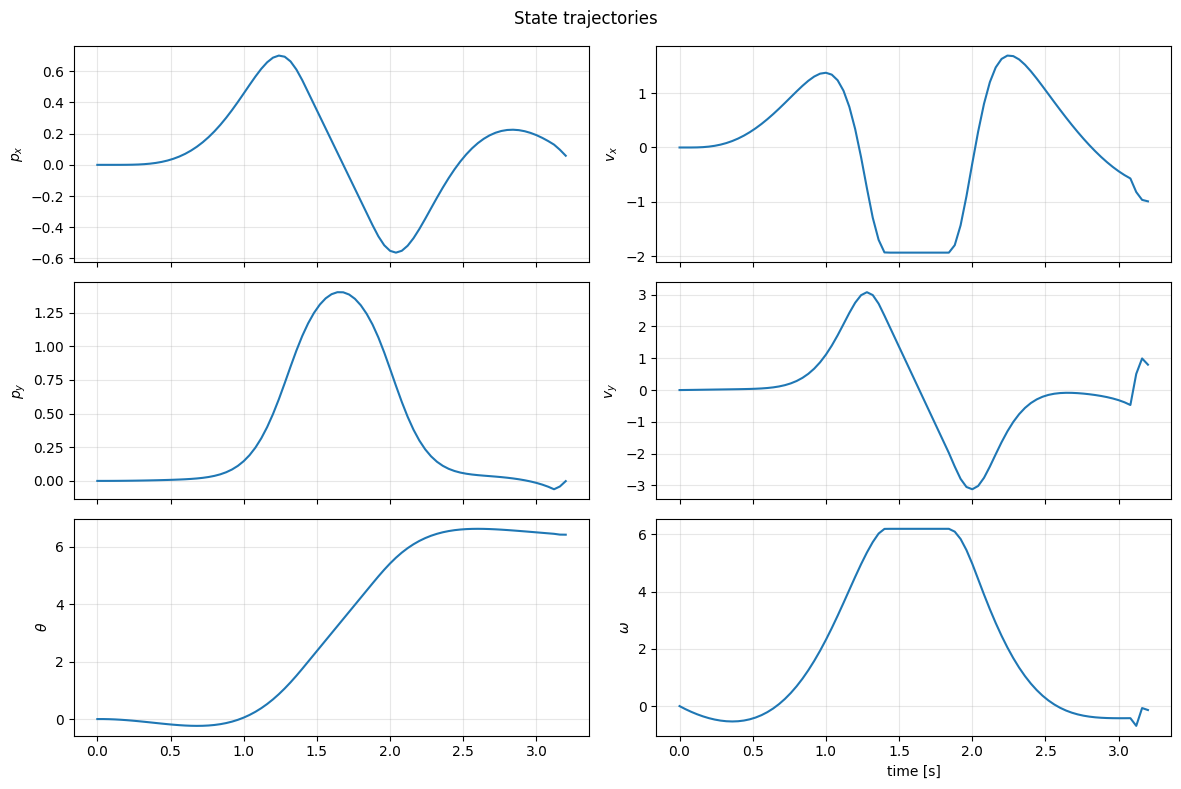

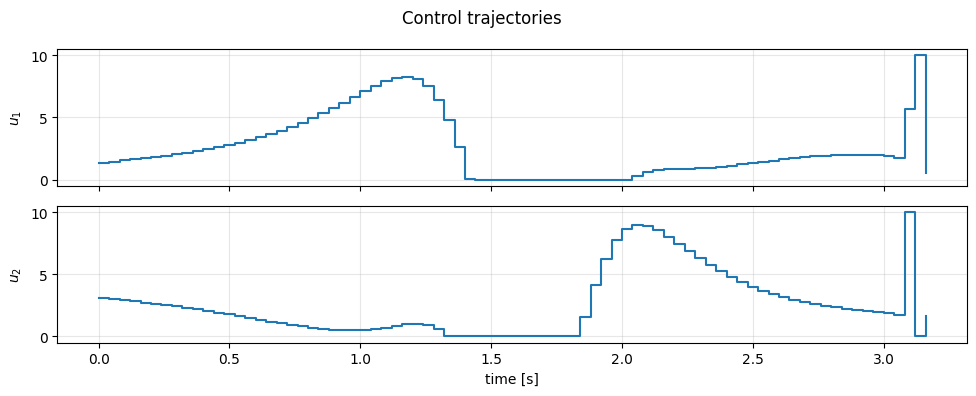

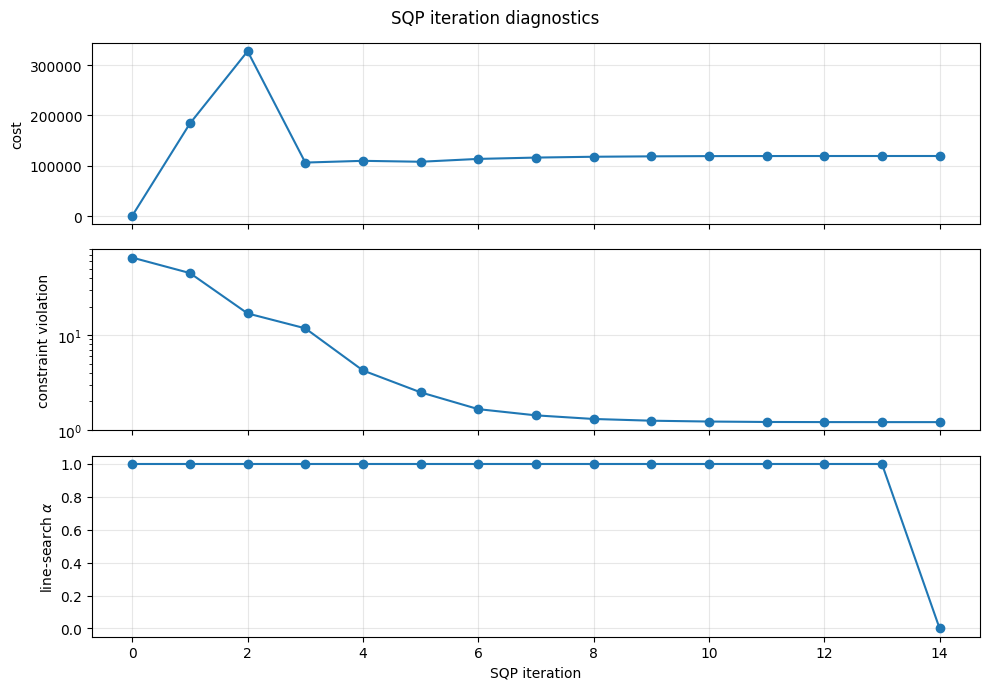

In [4]:
import numpy as np

import quadrotor
# from traj_opt import (
#     DIM_X,
#     build_default_options,
#     solve_sqp,
#     unpack_solution,
# )

# --- run the SQP trajectory optimizer ---
horizon = 80
opts = build_default_options(horizon)
x0 = np.zeros(DIM_X)

solution, history = solve_sqp(x0, opts)
x_traj, u_traj = unpack_solution(solution, horizon)

# --- print basic logs for inspection ---
print(f"Final theta (rad): {x_traj[-1, 4]:.3f}")
print(f"Line-search alphas: {[step['alpha'] for step in history if 'alpha' in step]}")
print(f"Constraint violation history: {[step['violation'] for step in history]}")

# --- state trajectories ---
state_labels = ["$p_x$", "$v_x$", "$p_y$", "$v_y$", "$\\theta$", "$\\omega$"]
time = np.arange(x_traj.shape[0]) * quadrotor.DT

fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True)
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.plot(time, x_traj[:, idx], label=state_labels[idx])
    ax.set_ylabel(state_labels[idx])
    ax.grid(alpha=0.3)
axes[-1].set_xlabel("time [s]")
fig.suptitle("State trajectories")
plt.tight_layout()

# --- control trajectories ---
fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
control_time = np.arange(u_traj.shape[0]) * quadrotor.DT
control_labels = ["$u_1$", "$u_2$"]
for idx, ax in enumerate(axes):
    ax.step(control_time, u_traj[:, idx], where="post", label=control_labels[idx])
    ax.set_ylabel(control_labels[idx])
    ax.grid(alpha=0.3)
axes[-1].set_xlabel("time [s]")
fig.suptitle("Control trajectories")
plt.tight_layout()

# --- SQP diagnostics ---
iters = [entry["iter"] for entry in history]
costs = [entry["cost"] for entry in history]
violations = [entry["violation"] for entry in history]
alphas = [entry.get("alpha", np.nan) for entry in history]

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
axes[0].plot(iters, costs, marker="o")
axes[0].set_ylabel("cost")
axes[0].grid(alpha=0.3)

axes[1].plot(iters, violations, marker="o")
axes[1].set_ylabel("constraint violation")
axes[1].set_yscale("log")
axes[1].grid(alpha=0.3)

axes[2].plot(iters, alphas, marker="o")
axes[2].set_ylabel("line-search $\\alpha$")
axes[2].set_xlabel("SQP iteration")
axes[2].grid(alpha=0.3)

fig.suptitle("SQP iteration diagnostics")
plt.tight_layout()
# --- show the animation in the notebook ---
quadrotor.animate_robot(x_traj.T, u_traj.T)

**1) Receding horizon with dynamic warm-start**

At control step $t$, we do not re-solve to full optimality. We:

- **Shift last cycle's controls forward:** $\hat{u}_0 \ldots \hat{u}_{N-2} \leftarrow u_1 \ldots u_{N-1}$, $\hat{u}_{N-1} \leftarrow u^{\text{ref}}$.

- **Forward-simulate** from the measured $x(t)$ to get a dynamically consistent state guess $\hat{x}_0 \ldots \hat{x}_N$:
  
  $$\hat{x}_0 = x^{\text{meas}}, \quad \hat{x}_{k+1} = \hat{x}_k + \Delta t \, f(\hat{x}_k, \hat{u}_k).$$
  
  This makes the initial equality linearization "well-posed".

- **Enforce a safety projection** only on altitude: $\hat{x}_{k,p_y} \leftarrow \max(\hat{x}_{k,p_y}, 0.05)$.

- **Pack** $\hat{z} = \text{col}(\hat{x}_0 \ldots \hat{x}_N, \hat{u}_0 \ldots \hat{u}_{N-1})$ and do 1–2 Newton/QP steps around it.

**In principle**: use dynamics-consistent warm-starts so the linearized QP is feasible/useful, then take only a handful of steps each cycle and move on.

**My Observation:** The very first QP sees $\Delta x_0$ constrained to 0 (injecting the measurement) and dynamics residuals near zero due to forward-simulation, so the linearized equalities $G\Delta z = -c(\hat{z})$ are solvable and steps are meaningful.

**2) Soft altitude safety as a QP slack (feasible-by-design)**

I augment $\Delta z$ with slacks $s \in \mathbb{R}^{N+1}$ and enforce, for all $k$:

$$p_{y,k} + s_k \geq -\text{margin}, \quad s_k \geq 0.$$

**QP variables:** $\Delta \tilde{z} = [\Delta z; s]$. **QP objective** extends Hessian with $w_s I$ on $s$:

$$\min \frac{1}{2} \Delta z^{\top} H \Delta z + q^{\top} \Delta z + \frac{1}{2} w_s s^{\top} s.$$

**Constraints in compact form (stacked):**

- **Equalities:** $[G \; 0] \Delta \tilde{z} = -c(\hat{z})$, plus $\Delta x_0 = 0$.
- **Thrust boxes:** $\ell_{\text{ctrl}} \leq \Delta u \leq u_{\text{ctrl}}$ (no slack).
- **Altitude:** $[E_{p_y} \; I] \Delta \tilde{z} \geq -\hat{p}_y - \text{margin}$, with $E_{p_y}$ extracting $p_y$ components from $\Delta z$.
- **Slack nonnegativity:** $s \geq 0$.

This ensures **feasibility** of the inner QP at each mpc step while strongly penalizing altitude violation.

**My Observation:** In mpc We can't afford infeasible subproblems. Slack variables guarantee a solution; $w_s$ drives $s \to 0$ as much as possible.

**3) Linear control bounds in $\Delta u$ (exactly convex at the linearization point)**

Thrust bounds appear as:

$$u_{\min} - \hat{u} \leq \Delta u \leq u_{\max} - \hat{u}.$$

This is the clean way to keep the QP convex and numerically well-behaved under mpc.

**My Observation:** Boxes in $\Delta u$ do not couple with dynamics linearization and keep OSQP fast.

**4) Stage angle wrapping (stability in the looped angle)**

Every stage uses $\theta$ error wrapped: $e_{\theta,k} = \text{wrap}(\theta_k - \theta_{\text{ref},k})$.

Terminal also wraps. This prevents artificial "$8\pi$ vs $0$" large errors that would mislead the QP.

**My Observation:** Without this I observed the controller would keep "chasing" new turns instead of consolidating a completed $2\pi$.

**5) Filter acceptance (simple but forgiving)**

The line-search filter accepts $\alpha$ if either cost improves or violation improves (not both). This is simpler than a strict filter and helps RTI keep $\alpha \approx 1$.

**Result:** most cycles accept $\alpha=1.0$, avoiding step rejections that stall updates.

**My Observation:** In receding horizon We must keep moving; a strict filter often rejects steps once violation is large.

**6) Robustness ladder for the inner QP (keep control online)**

If the QP fails at the nominal margin, I put a code block to automatically retry with a relaxed altitude margin (e.g., 0.5 m).

If that still fails, Code falls back to zero step (apply warm-start control).

It also accept OSQP "max-iter" solutions if equality residual is small.

**My Observation:** mpc is online; I need to produce a control every $\Delta t$. This ladder prevents controller drop-outs without derailing safety.

**7) Objective shaping tuned for MPC (not for a single long solve)**

Weights emphasize altitude and vertical speed $(p_y, v_y)$, slightly de-emphasize $\theta$ relative to Part 1, and raise $R$ to discourage impulsive thrust.

**Interpretation:** Near real time with disturbances, altitude preservation and smooth control dominate; orientation will align as dynamics allow.

**My Observation:** With short horizons I encoded short-term priorities (don't fall, don't saturate) directly into the stage cost.

**8) Measurement injection via $\Delta x_0 = 0$ (tight feedback)**

The QP enforces $\Delta x_0 = 0$, i.e., $x_0$ in the decision equals the measured state exactly at each cycle.

This is the MPC's "state-feedback" step; all downstream states/controls are optimized relative to the fresh measurement.

**My Observation:** This is the key MPC distinction vs offline trajectory optimization; it reacts to perturbations immediately.

**9) Diagnostics for mpc health (practical)**

You log per-control-step tuples: $\{\text{time}, \text{cost}, \text{violation}, \alpha, \text{min\_altitude}\}$.

Observing $\alpha \approx 1$ and violation trending down is a health check; spikes point to bad warm-starts or too-short horizon.

**My Observation:** In mpc I think we can judge solver health by these coarse metrics, not by tight KKT residuals (you rarely run to convergence each cycle).

**10) Mathematical skeleton of each MPC cycle (unique to this implementation)**

Given $x^{\text{meas}}(t)$, warm-start $(\hat{x}, \hat{u})$, compute one (or two) RTI steps:

**Build QP:**

- **Variables:** $\Delta \tilde{z} = [\Delta x_0 \ldots \Delta x_N, \Delta u_0 \ldots \Delta u_{N-1}, s_0 \ldots s_N]$.

- **Objective:**
  
  $$\frac{1}{2} \Delta z^{\top} H \Delta z + q^{\top} \Delta z + \frac{1}{2} w_s s^{\top} s,$$
  
  with $H, q$ from quadraticization of $J$ around $\hat{z}$ ($\theta$ wrapped).

- **Equalities:**
  
  $$G \Delta z = -c(\hat{z}), \quad \Delta x_0 = 0.$$

- **Inequalities:**
  
  $$u_{\min} - \hat{u} \leq \Delta u \leq u_{\max} - \hat{u},$$
  
  $$E_{p_y} \Delta z + s \geq -\hat{p}_y - \text{margin}, \quad s \geq 0.$$

**Solve QP** (OSQP, accept robustly).

**Line search** on $\alpha$; set $z \leftarrow \hat{z} + \alpha[\Delta z; 0]$ (slack is dropped from the warm-start).

**Apply control** $u(t) =$ first row of $u$ extracted from $z$.

**Shift and repeat** next cycle.

In [ ]:
#!/usr/bin/env python3
"""
MPC
"""

from __future__ import annotations

import dataclasses
from typing import Callable, Sequence, Tuple

import numpy as np
import scipy.sparse as sp

try:
    import osqp  # fast sparse QP solver (pip install osqp)
except ImportError as exc:
    raise ImportError("Please install OSQP (pip install osqp)") from exc

import quadrotor


# Problem data container                                                       


@dataclasses.dataclass
class SQPOptions:
    horizon: int
    Q: np.ndarray
    R: np.ndarray
    Qf: np.ndarray
    state_ref: Callable[[int], np.ndarray]
    control_ref: Callable[[int], np.ndarray]
    dt: float = quadrotor.DT
    mass: float = quadrotor.MASS
    inertia: float = quadrotor.INERTIA
    arm: float = quadrotor.LENGTH
    gravity: float = quadrotor.GRAVITY_CONSTANT
    thrust_min: float = 0.0
    thrust_max: float = 10.0
    max_iters: int = 80
    tol: float = 1e-4
    line_search_rho: float = 0.5
    min_alpha: float = 1e-6
    altitude_margin: float = 0.05
    altitude_floor: float = 0.1
    slack_weight: float = 1e6  # Strong penalty to discourage slack usage
    enable_x_tube: bool = True
    x_tube_radius: float = 0.10  # meters
    qp_iters_per_step: int = 3  # Real-time SQP iterations per MPC step

DIM_X = quadrotor.DIM_STATE
DIM_U = quadrotor.DIM_CONTROL

# Step 1: Forward Euler discrete dynamics                                     #

def euler_step(x: np.ndarray, u: np.ndarray, opts: SQPOptions) -> np.ndarray:
    """x_{k+1} = x_k + Δt f(x_k,u_k)."""
    px, vx, py, vy, theta, omega = x
    u1, u2 = u
    u_sum = u1 + u2
    u_diff = u1 - u2

    f = np.array([
        vx,
        -(u_sum / opts.mass) * np.sin(theta),
        vy,
        (u_sum / opts.mass) * np.cos(theta) - opts.gravity,
        omega,
        (opts.arm / opts.inertia) * u_diff,
    ])
    return x + opts.dt * f


def dynamics_residual(z: np.ndarray, opts: SQPOptions) -> np.ndarray:
    """Stack c_k(x_k,u_k,x_{k+1}) = x_{k+1} - step(x_k,u_k) for k=0..N-1."""
    N = opts.horizon
    x_blocks = z[: (N + 1) * DIM_X].reshape(N + 1, DIM_X)
    u_blocks = z[(N + 1) * DIM_X:].reshape(N, DIM_U)
    residuals = []
    for k in range(N):
        residuals.append(euler_step(x_blocks[k], u_blocks[k], opts) - x_blocks[k + 1])
    return np.concatenate(residuals)


def dynamics_jacobian(z: np.ndarray, opts: SQPOptions) -> sp.coo_matrix:
    """Sparse Jacobian G(z) = ∂c/∂z with banded block structure."""
    N = opts.horizon
    x_blocks = z[: (N + 1) * DIM_X].reshape(N + 1, DIM_X)
    u_blocks = z[(N + 1) * DIM_X:].reshape(N, DIM_U)

    rows, cols, data = [], [], []

    def add_block(row_base: int, col_base: int, block: np.ndarray) -> None:
        nz_rows, nz_cols = np.nonzero(block)
        rows.extend(row_base + nz_rows)
        cols.extend(col_base + nz_cols)
        data.extend(block[nz_rows, nz_cols])

    I_x = np.eye(DIM_X)
    for k in range(N):
        theta = x_blocks[k, 4]
        u1, u2 = u_blocks[k]
        u_sum = u1 + u2
        sin_th, cos_th = np.sin(theta), np.cos(theta)

        A = I_x.copy()
        A[1, 4] += -opts.dt * (u_sum / opts.mass) * cos_th
        A[3, 4] += -opts.dt * (u_sum / opts.mass) * sin_th
        A[4, 5] += opts.dt

        B = np.zeros((DIM_X, DIM_U))
        B[1, :] = -opts.dt * sin_th / opts.mass
        B[3, :] = opts.dt * cos_th / opts.mass
        B[5, 0] = opts.dt * opts.arm / opts.inertia
        B[5, 1] = -opts.dt * opts.arm / opts.inertia

        row_offset = k * DIM_X
        add_block(row_offset, k * DIM_X, A)
        add_block(row_offset, (k + 1) * DIM_X, -I_x)
        ctrl_col = (N + 1) * DIM_X + k * DIM_U
        add_block(row_offset, ctrl_col, B)

    total_cols = (N + 1) * DIM_X + N * DIM_U
    return sp.coo_matrix((data, (rows, cols)), shape=(N * DIM_X, total_cols))


# Steps 2–3: Cost, gradients, Hessians                                        

def reference_state(opts: SQPOptions, k: int) -> np.ndarray:
    return opts.state_ref(k)


def reference_control(opts: SQPOptions, k: int) -> np.ndarray:
    return opts.control_ref(k)


def cost_grad_hess(z: np.ndarray, opts: SQPOptions) -> Tuple[float, np.ndarray, np.ndarray]:
    N = opts.horizon
    x_blocks = z[: (N + 1) * DIM_X].reshape(N + 1, DIM_X)
    u_blocks = z[(N + 1) * DIM_X:].reshape(N, DIM_U)

    cost = 0.0
    grad = np.zeros_like(z)
    H_diag = np.zeros_like(z)

    for k in range(N):
        x_err = x_blocks[k] - reference_state(opts, k)
        x_err[4] = wrap_angle(x_err[4])  # ← ADD THIS: wrap theta at every stage
        u_err = u_blocks[k] - reference_control(opts, k)

        cost += x_err @ opts.Q @ x_err + u_err @ opts.R @ u_err
        grad[k * DIM_X:(k + 1) * DIM_X] += 2.0 * opts.Q @ x_err
        ctrl_slice = (N + 1) * DIM_X + k * DIM_U
        grad[ctrl_slice:ctrl_slice + DIM_U] += 2.0 * opts.R @ u_err

        H_diag[k * DIM_X:(k + 1) * DIM_X] += np.diag(2.0 * opts.Q)
        H_diag[ctrl_slice:ctrl_slice + DIM_U] += np.diag(2.0 * opts.R)

    xN_err = x_blocks[-1] - reference_state(opts, N)
    xN_err[4] = wrap_angle(xN_err[4])
    cost += xN_err @ opts.Qf @ xN_err
    grad[-DIM_X:] += 2.0 * opts.Qf @ xN_err
    H_diag[-DIM_X:] += np.diag(2.0 * opts.Qf)

    # Remove or greatly reduce the explicit altitude penalty (already in constraint)
    # The slack penalty handles this better
    
    return cost, grad, H_diag


def build_default_options(horizon: int) -> SQPOptions:
    Q = np.diag([40.0, 4.0, 400.0, 8.0, 30.0, 6.0])  # ↑p_y: 200→400, ↑v_y: 4→8, ↓θ: 60→30
    R = np.diag([2.0, 2.0])  # ↑ control cost to avoid thrust spikes
    Qf = np.diag([320.0, 40.0, 3200.0, 80.0, 240.0, 60.0])  # Scale terminal weights similarly
    
    return SQPOptions(
        horizon=horizon,
        Q=Q,
        R=R,
        Qf=Qf,
        state_ref=default_reference_factory(horizon),
        control_ref=lambda k: default_control_reference(k),
    )


def wrap_angle(angle: float) -> float:
    return (angle + np.pi) % (2.0 * np.pi) - np.pi


# Steps 5–6: QP subproblem and solver                                         


def solve_qp_subproblem(
    H_diag: np.ndarray,
    grad: np.ndarray,
    G: sp.csc_matrix,
    constr: np.ndarray,
    z: np.ndarray,
    opts: SQPOptions,
) -> np.ndarray:
    """Solve min ½ΔzᵀHΔz + gradᵀΔz s.t. GΔz = -constr, thrust bounds, and altitude bounds (with slack)."""
    N = opts.horizon
    n = H_diag.size
    num_slack_alt = N + 1
    num_slack_px = (N + 1) if opts.enable_x_tube and opts.x_tube_radius > 0.0 else 0
    num_slack = num_slack_alt + num_slack_px

    # Extend Hessian/gradient for slack variables
    H_extended = sp.diags(
        np.concatenate([np.maximum(H_diag, 1e-9), np.full(num_slack, opts.slack_weight)])
    )
    q_extended = np.concatenate([grad.copy(), np.zeros(num_slack, dtype=float)])

    # Equality: G Δz = -constr; fix Δx0 = 0 (slack doesn't affect equalities)
    A_eq_dynamics = G
    A_eq_init = sp.coo_matrix(
        (np.ones(DIM_X), (np.arange(DIM_X), np.arange(DIM_X))),
        shape=(DIM_X, n),
    ).tocsc()
    A_eq_slack = sp.coo_matrix((DIM_X + N * DIM_X, num_slack))
    A_eq = sp.hstack([sp.vstack([A_eq_dynamics, A_eq_init]), A_eq_slack]).tocsc()
    l_eq = np.concatenate([-constr, np.zeros(DIM_X)])
    u_eq = l_eq.copy()

    # Inequality: thrust bounds → linear on Δu (no slack)
    ctrl_offset = (N + 1) * DIM_X
    num_ctrl = N * DIM_U
    idx = np.arange(num_ctrl)
    A_ctrl = sp.coo_matrix(
        (np.ones(num_ctrl), (idx, ctrl_offset + idx)),
        shape=(num_ctrl, n),
    ).tocsc()
    A_ctrl_slack = sp.coo_matrix((num_ctrl, num_slack))
    A_ctrl_full = sp.hstack([A_ctrl, A_ctrl_slack]).tocsc()
    u_curr = z[ctrl_offset:]
    l_ctrl = np.full(num_ctrl, opts.thrust_min) - u_curr
    u_ctrl = np.full(num_ctrl, opts.thrust_max) - u_curr

    # Altitude constraint with slack: p_y + s >= -margin
    x_curr = z[: (N + 1) * DIM_X]
    alt_row_idx = np.arange(N + 1)
    alt_col_idx = (np.arange(N + 1) * DIM_X) + 2
    alt_data = np.ones(N + 1)
    A_alt_x = sp.coo_matrix(
        (alt_data, (alt_row_idx, alt_col_idx)),
        shape=(N + 1, n),
    ).tocsc()
    A_alt_s = sp.coo_matrix(
        (np.ones(N + 1), (alt_row_idx, alt_row_idx)),
        shape=(N + 1, num_slack),
    ).tocsc()
    # Hard altitude constraint: Δp_y >= -p_y_curr (so p_y_new >= 0)
    A_alt_hard = sp.coo_matrix(
        (alt_data, (alt_row_idx, alt_col_idx)),
        shape=(N + 1, n),
    ).tocsc()
    l_alt_hard = -x_curr[alt_col_idx]  # p_y_curr + Δp_y >= 0
    u_alt_hard = np.full(N + 1, np.inf)
    A_alt_full = sp.hstack([A_alt_x, A_alt_s]).tocsc()
    l_alt = -x_curr[alt_col_idx] + opts.altitude_floor
    u_alt = np.full(N + 1, np.inf)

    # Optional x-position tube via slack: |p_x - p_x_ref| <= radius + s_x
    A_px_stack = None
    l_px = None
    u_px = None
    if opts.enable_x_tube and num_slack_px > 0 and opts.x_tube_radius > 0.0:
        px_row_idx = np.arange(N + 1)
        px_col_idx = (np.arange(N + 1) * DIM_X) + 0
        A_px_pos_x = sp.coo_matrix(
            (np.ones(N + 1), (px_row_idx, px_col_idx)),
            shape=(N + 1, n),
        ).tocsc()
        s_offset = num_slack_alt
        A_px_pos_s = sp.coo_matrix(
            (np.ones(N + 1), (px_row_idx, s_offset + px_row_idx)),
            shape=(N + 1, num_slack),
        ).tocsc()
        A_px_pos_full = sp.hstack([A_px_pos_x, A_px_pos_s]).tocsc()

        A_px_neg_x = (-A_px_pos_x).tocsc()
        A_px_neg_s = A_px_pos_s
        A_px_neg_full = sp.hstack([A_px_neg_x, A_px_neg_s]).tocsc()

        px_ref = np.array([reference_state(opts, k)[0] for k in range(N + 1)], dtype=float)
        px_curr = x_curr[px_col_idx]
        l_px_pos = px_ref - px_curr - opts.x_tube_radius
        l_px_neg = -(px_ref - px_curr) - opts.x_tube_radius
        l_px = np.concatenate([l_px_pos, l_px_neg])
        u_px = np.full(2 * (N + 1), np.inf)

        A_px_stack = sp.vstack([A_px_pos_full, A_px_neg_full]).tocsc()

    # Slack non-negativity: s >= 0
    A_slack = sp.hstack([
        sp.coo_matrix((num_slack, n)),
        sp.eye(num_slack)
    ]).tocsc()
    l_slack = np.zeros(num_slack)
    u_slack = np.full(num_slack, np.inf)

    # Stack all constraints
    blocks = [A_eq, A_ctrl_full, A_alt_full]
    lows = [l_eq, l_ctrl, l_alt]
    ups = [u_eq, u_ctrl, u_alt]
    if A_px_stack is not None:
        blocks.append(A_px_stack)
        lows.append(l_px)
        ups.append(u_px)
    blocks.append(A_slack)
    A = sp.vstack(blocks).tocsc()
    l = np.concatenate(lows + [l_slack])
    u = np.concatenate(ups + [u_slack])

    solver = osqp.OSQP()
    # Increased max_iter and added regularization for better convergence
    solver.setup(
        P=H_extended, 
        q=q_extended, 
        A=A, 
        l=l, 
        u=u, 
        eps_abs=1e-5,  # Slightly relaxed for faster convergence
        eps_rel=1e-5,
        max_iter=20000,  # Increased from default ~4000
        rho=0.1,  # ADMM step size (lower = more stable but slower)
        adaptive_rho=True,  # Let OSQP adapt the step size
        polish=True,  # Polish solution for better accuracy
        verbose=False
    )
    result = solver.solve()
    
    # Accept solutions that converged or reached max_iter with reasonable progress
    if result.info.status_val not in (1, 2):
        # Check if we got a reasonable solution despite max_iter
        if result.info.status_val == -3:  # maximum iterations reached
            # If solution exists and constraint violations are reasonable, use it
            if result.x is not None and len(result.x) > 0:
                # Check if solution satisfies constraints approximately
                x_sol = result.x[:n]
                # Compute constraint violations
                eq_viol = np.linalg.norm(A_eq @ result.x - l_eq[:A_eq.shape[0]], ord=np.inf)
                if eq_viol < 1e-2:  # Accept if equality violations are small
                    print(f"[QP DEBUG] Using solution despite max_iter (eq_viol={eq_viol:.2e})")
                    return x_sol
        
        print("[QP DEBUG] status:", result.info.status)
        print("[QP DEBUG] control bounds rhs range:",
              float(l_ctrl.min()), float(l_ctrl.max()),
              float(u_ctrl.min()), float(u_ctrl.max()))
        print("[QP DEBUG] altitude rhs min/max:",
              float(l_alt.min()), float(l_alt.max()))
        print("[QP DEBUG] min altitude in guess:",
              float(x_curr[alt_col_idx].min()))
        print("[QP DEBUG] dynamics residual inf-norm:",
              float(np.linalg.norm(constr, ord=np.inf)))
        raise RuntimeError(f"OSQP failed: {result.info.status}")
    
    # Return only the decision variable increments (drop slack)
    return result.x[:n]


#Constraint violation

def constraint_violation(z: np.ndarray, opts: SQPOptions) -> float:
    N = opts.horizon
    x_blocks = z[: (N + 1) * DIM_X].reshape(N + 1, DIM_X)
    u_blocks = z[(N + 1) * DIM_X:].reshape(N, DIM_U)

    dyn_violation = dynamics_residual(z, opts)
    accum = np.sum(np.abs(dyn_violation))

    for k in range(N):
        accum += np.sum(np.maximum(0.0, opts.thrust_min - u_blocks[k]))
        accum += np.sum(np.maximum(0.0, u_blocks[k] - opts.thrust_max))

    # Add altitude violations w.r.t. floor
    for k in range(N + 1):
        accum += max(0.0, opts.altitude_floor - x_blocks[k, 2])

    if opts.enable_x_tube and opts.x_tube_radius > 0.0:
        radius = opts.x_tube_radius
        for k in range(N + 1):
            px_ref = reference_state(opts, k)[0]
            accum += max(0.0, abs(x_blocks[k, 0] - px_ref) - radius)

    accum += np.linalg.norm(x_blocks[0] - reference_state(opts, 0), ord=1)
    return accum


def filter_line_search(
    z: np.ndarray,
    step: np.ndarray,
    cost_curr: float,
    viol_curr: float,
    metric_fn: Callable[[np.ndarray], Tuple[float, float]],
    opts: SQPOptions,
    f_best: float,
    c_best: float,
) -> Tuple[np.ndarray, float, float, float, float, float]:
    alpha = 1.0
    while alpha > opts.min_alpha:
        z_trial = z + alpha * step
        cost_trial, viol_trial = metric_fn(z_trial)
        
        # Simpler acceptance: cost OR violation improvement (like Part 1)
        if cost_trial < f_best or viol_trial < c_best:
            return z_trial, alpha, min(f_best, cost_trial), min(c_best, viol_trial), cost_trial, viol_trial
        
        alpha *= opts.line_search_rho
    return z, 0.0, f_best, c_best, cost_curr, viol_curr

# Outer SQP routine                                                  

def solve_sqp(x_init: np.ndarray, opts: SQPOptions, z0: np.ndarray | None = None):
    N = opts.horizon
    total_states = (N + 1) * DIM_X
    total_controls = N * DIM_U

    if z0 is not None:
        z = z0.copy()
        z[:DIM_X] = x_init
    else:
        x_blocks = np.zeros((N + 1, DIM_X))
        for k in range(N + 1):
            x_blocks[k] = reference_state(opts, k)
        x_blocks[0] = x_init

        u_blocks = np.zeros((N, DIM_U))
        for k in range(N):
            x_curr = x_blocks[k]
            ref_next = reference_state(opts, k + 1)

            theta = x_curr[4]
            sin_th = np.sin(theta)
            cos_th = np.cos(theta)

            A_coeffs = []
            b_vals = []

            coeff_vx = -opts.dt * sin_th / opts.mass
            A_coeffs.append(coeff_vx)
            b_vals.append(ref_next[1] - x_curr[1])

            coeff_vy = opts.dt * cos_th / opts.mass
            if abs(cos_th) > 1e-6:
                A_coeffs.append(coeff_vy)
                b_vals.append(ref_next[3] - x_curr[3] + opts.dt * opts.gravity)

            A = np.array(A_coeffs, dtype=float).reshape(-1, 1)
            b = np.array(b_vals, dtype=float)
            if A.size == 0:
                u_sum = 2.0 * opts.mass * opts.gravity
            else:
                u_sum = float(np.linalg.lstsq(A, b, rcond=None)[0])

            u_diff = (opts.inertia / (opts.arm * opts.dt)) * (ref_next[5] - x_curr[5])
            u = np.array([(u_sum + u_diff) * 0.5, (u_sum - u_diff) * 0.5])
            u = np.clip(u, opts.thrust_min + 1e-6, opts.thrust_max - 1e-6)
            u_blocks[k] = u

            x_prop = euler_step(x_curr, u, opts)
            x_blocks[k + 1] = 0.5 * x_prop + 0.5 * ref_next

        z = np.concatenate([x_blocks.reshape(-1), u_blocks.reshape(-1)])

    history = []
    f_best = np.inf
    c_best = np.inf

    for it in range(opts.max_iters):
        cost, grad, H_diag = cost_grad_hess(z, opts)
        constr = dynamics_residual(z, opts)
        viol = constraint_violation(z, opts)

        history.append({"iter": it, "cost": cost, "violation": viol})

        if viol < opts.tol and np.linalg.norm(grad, ord=np.inf) < opts.tol:
            break

        G = dynamics_jacobian(z, opts).tocsc()
        step = solve_qp_subproblem(H_diag, grad, G, constr, z, opts)


        def metric(z_trial: np.ndarray) -> Tuple[float, float]:
            c_val, _, _ = cost_grad_hess(z_trial, opts)
            v_val = constraint_violation(z_trial, opts)
            return c_val, v_val

        z_new, alpha, f_best, c_best, cost_new, viol_new = filter_line_search(
            z, step, cost, viol, metric, opts, f_best, c_best
        )
        history[-1].update({"alpha": alpha, "cost_new": cost_new, "violation_new": viol_new})

        if alpha == 0.0:
            print("Line search failed to find acceptable step.")
            break
        z = z_new

    return z, history


# Utility to extract trajectories and run demo                               

def unpack_solution(z: np.ndarray, N: int) -> Tuple[np.ndarray, np.ndarray]:
    x_traj = z[: (N + 1) * DIM_X].reshape(N + 1, DIM_X)
    u_traj = z[(N + 1) * DIM_X:].reshape(N, DIM_U)
    return x_traj, u_traj


def default_reference_factory(N: int) -> Callable[[int], np.ndarray]:
    t_grid = np.linspace(0.0, 1.0, N + 1)
    
    def ref(k: int) -> np.ndarray:
        t = t_grid[k]
        theta = 2.0 * np.pi * t
        px = 1.0 * np.sin(2.0 * np.pi * t)
        py = 1.2 + 0.4 * (1.0 - np.cos(2.0 * np.pi * t))  # Simple, stays in [0.8, 1.6]
        return np.array([px, 0.0, py, 0.0, theta, 0.0])
    
    return ref

def default_control_reference(_: int) -> np.ndarray:
    thrust_hover = quadrotor.MASS * quadrotor.GRAVITY_CONSTANT / 2.0
    return np.array([thrust_hover, thrust_hover])


def build_default_options(horizon: int) -> SQPOptions:
    Q = np.diag([400.0, 40.0, 400.0, 80.0, 60.0, 6.0])  
    R = np.diag([20.0, 20.0])  # ↑ control cost to avoid thrust spikes
    Qf = np.diag([3200.0, 400.0, 3200.0, 800.0, 240.0, 600.0])  # Scale terminal weights similarly
    
    return SQPOptions(
        horizon=horizon,
        Q=Q,
        R=R,
        Qf=Qf,
        state_ref=default_reference_factory(horizon),
        control_ref=lambda k: default_control_reference(k),
        altitude_floor=0.05,
        slack_weight=1e6,
        enable_x_tube=True,
        x_tube_radius=0.30,
    )


def forward_simulate_trajectory(x0: np.ndarray, u_traj: np.ndarray, opts: SQPOptions) -> np.ndarray:
    """Forward simulate to get dynamically consistent state trajectory."""
    N = opts.horizon
    x_traj = np.zeros((N + 1, DIM_X))
    x_traj[0] = x0
    for k in range(N):
        x_traj[k + 1] = euler_step(x_traj[k], u_traj[k], opts)
    return x_traj


@dataclasses.dataclass
class SQPMPC:
    """Real-time iteration SQP MPC using one Newton step per control cycle."""
    opts: SQPOptions
    debug: bool = False
    warm_start: np.ndarray | None = None
    info_history: list[dict] = dataclasses.field(default_factory=list)

    def reset(self, x0: np.ndarray) -> None:
        """Compute a full SQP solution for the current state and use it as warm start."""
        if self.debug:
            print("[MPC] Warm-starting with full SQP solve …")
        z_guess = None
        history_accum: list[dict] = []
        for margin in (2.0, 0.5, 0.1, self.opts.altitude_margin):
            temp_opts = dataclasses.replace(self.opts, altitude_margin=margin)
            try:
                z_guess, history = solve_sqp(x0, temp_opts, z0=z_guess)
            except RuntimeError as exc:
                if self.debug:
                    print(f"[MPC] Warm-start stage with margin {margin} failed: {exc}")
                break
            x_proj = z_guess[: (self.opts.horizon + 1) * DIM_X].reshape(
                self.opts.horizon + 1, DIM_X
            )
            x_proj[:, 2] = np.maximum(x_proj[:, 2], 0.0)
            z_guess[: (self.opts.horizon + 1) * DIM_X] = x_proj.reshape(-1)
            history_accum.extend(history)

        self.warm_start = z_guess
        self.info_history = history_accum

    def _build_shifted_guess(self, x_meas: np.ndarray) -> np.ndarray:
        N = self.opts.horizon
        total_states = (N + 1) * DIM_X
        total_controls = N * DIM_U

        if self.warm_start is None:
            self.reset(x_meas)

        prev = self.warm_start
        x_prev = prev[:total_states].reshape(N + 1, DIM_X)
        u_prev = prev[total_states:].reshape(N, DIM_U)

        # Shift controls
        u_guess = np.zeros_like(u_prev)
        u_guess[:-1] = u_prev[1:]
        u_guess[-1] = self.opts.control_ref(N - 1)
        
        # Forward simulate (dynamically consistent)
        x_guess = forward_simulate_trajectory(x_meas, u_guess, self.opts)
        
        # Project altitude to be above the configured floor with a small buffer
        x_guess[:, 2] = np.maximum(x_guess[:, 2], self.opts.altitude_floor + 0.05)

        if self.opts.enable_x_tube and self.opts.x_tube_radius > 0.0:
            px_ref = np.array([reference_state(self.opts, k)[0] for k in range(N + 1)], dtype=float)
            radius = self.opts.x_tube_radius
            x_guess[:, 0] = np.clip(x_guess[:, 0], px_ref - radius, px_ref + radius)
        
        # DON'T blend with reference during MPC - trust the simulation
        # (Only blend during initial warm-start in reset())
        
        return np.concatenate([x_guess.reshape(-1), u_guess.reshape(-1)])

    def control(self, x_meas: np.ndarray, t_idx: int) -> np.ndarray:
        """Perform one SQP iteration around the warm start and return the first control."""
        z_work = self._build_shifted_guess(x_meas)

        def metric(z_trial: np.ndarray) -> tuple[float, float]:
            trial_cost, _, _ = cost_grad_hess(z_trial, self.opts)
            trial_violation = constraint_violation(z_trial, self.opts)
            return trial_cost, trial_violation

        cost_work, grad_work, H_diag_work = cost_grad_hess(z_work, self.opts)
        constr_work = dynamics_residual(z_work, self.opts)
        violation_work = constraint_violation(z_work, self.opts)

        if self.debug:
            print(
                f"[MPC] t={t_idx:03d}, iter 0: cost={cost_work:.3f}, violation={violation_work:.2e}"
            )

        alpha = 0.0
        for iter_idx in range(self.opts.qp_iters_per_step):
            G_work = dynamics_jacobian(z_work, self.opts).tocsc()
            step = None
            try:
                step = solve_qp_subproblem(
                    H_diag_work.copy(),
                    grad_work.copy(),
                    G_work,
                    constr_work.copy(),
                    z_work,
                    self.opts,
                )
            except RuntimeError:
                if self.debug:
                    print(
                        f"[MPC] t={t_idx:03d}, iter {iter_idx}: QP failed, trying relaxed margin fallback"
                    )
                try:
                    relaxed_opts = dataclasses.replace(self.opts, altitude_margin=0.5)
                    step = solve_qp_subproblem(
                        H_diag_work.copy(),
                        grad_work.copy(),
                        G_work,
                        constr_work.copy(),
                        z_work,
                        relaxed_opts,
                    )
                except RuntimeError:
                    if self.debug:
                        print(
                            f"[MPC] t={t_idx:03d}, iter {iter_idx}: Relaxed margin failed, using zero step"
                        )
                    step = np.zeros_like(z_work)

            z_candidate, alpha, _, _, cost_new, violation_new = filter_line_search(
                z_work,
                step,
                cost_work,
                violation_work,
                metric,
                self.opts,
                f_best=np.inf,
                c_best=np.inf,
            )

            if self.debug:
                print(
                    f"[MPC] t={t_idx:03d}, iter {iter_idx}: alpha={alpha:.2f}, cost={cost_new:.3f}, "
                    f"violation={violation_new:.2e}"
                )

            if alpha == 0.0:
                break

            z_work = z_candidate
            cost_work, grad_work, H_diag_work = cost_grad_hess(z_work, self.opts)
            constr_work = dynamics_residual(z_work, self.opts)
            violation_work = constraint_violation(z_work, self.opts)

        N = self.opts.horizon
        total_states = (N + 1) * DIM_X
        x_blocks = z_work[:total_states].reshape(N + 1, DIM_X)
        u_blocks = z_work[total_states:].reshape(N, DIM_U)

        min_alt = float(x_blocks[:, 2].min())
        u_min = float(u_blocks.min())
        u_max = float(u_blocks.max())

        if self.debug:
            print(
                f"[MPC] t={t_idx:03d}: final cost={cost_work:.3f}, violation={violation_work:.2e}, "
                f"min(p_y)={min_alt:.3f}, u∈[{u_min:.2f}, {u_max:.2f}]"
            )

        self.warm_start = z_work
        self.info_history.append(
            {
                "time": t_idx,
                "cost": cost_work,
                "violation": violation_work,
                "alpha": alpha,
                "min_altitude": min_alt,
            }
        )

        return u_blocks[0].copy()


[MPC] Warm-starting with full SQP solve …


/tmp/ipykernel_77646/2890618891.py:455: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_sum = float(np.linalg.lstsq(A, b, rcond=None)[0])
/home/amey/miniconda3/lib/python3.12/site-packages/osqp/interface.py:226: UserWarning: Converting sparse P to a CSC matrix. This may take a while...
  warnings.warn('Converting sparse P to a CSC matrix. This may take a while...')


Line search failed to find acceptable step.
Line search failed to find acceptable step.
Line search failed to find acceptable step.
Line search failed to find acceptable step.
[MPC] t=000, iter 0: cost=114369.305, violation=5.79e+00
[MPC] t=000, iter 0: alpha=1.00, cost=142720.810, violation=3.58e+01
[MPC] t=000: final cost=142720.810, violation=3.58e+01, min(p_y)=-0.354, u∈[-0.00, 10.00]
[MPC] t=001, iter 0: cost=95023.880, violation=4.28e+00
[MPC] t=001, iter 0: alpha=1.00, cost=84845.257, violation=2.35e+01
[MPC] t=001: final cost=84845.257, violation=2.35e+01, min(p_y)=0.100, u∈[-0.00, 8.46]
[MPC] t=002, iter 0: cost=95962.078, violation=4.89e+00
[MPC] t=002, iter 0: alpha=1.00, cost=90516.927, violation=1.32e+01
[MPC] t=002: final cost=90516.927, violation=1.32e+01, min(p_y)=-0.317, u∈[-0.00, 8.35]
[MPC] t=003, iter 0: cost=83058.344, violation=3.82e+00
[MPC] t=003, iter 0: alpha=1.00, cost=82439.209, violation=8.63e+00
[MPC] t=003: final cost=82439.209, violation=8.63e+00, min(p_

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAqv5tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI3
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EWJliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/6j8nr/CzzxB7c42BR
aqfsCisz4sCaS28DFytPt6Y/JixzaQPceIXKg+8AF3VZ3CpIu9YAlvlnXske2obryrrIiSvziYtq
9xvi0R3TvRrRv1mxOOREDXkf5gu4VQJC8cMha17qTiTN8HhirVVd7fJx49q7tGP20dpE3VYns3/V
n3Qaffk8Qk40K8+qSaGSxqc/lekLsPbXxTxhaPivuO0eQGq91Pwe5RR/7Yz9OD1qUOa4HkdiifqP
j2qryhJc6ZstytCa5kKuYYe772IBvsCuHUC4S5av6px3pbaP+GKSwPpDS/4MQWMF/UdjKAjeYi2d
38QbSWbqBNqgQXYZ14f61ui2yM6GOIg7ws1/8vyTk5+nchva+A4izEYbmdjzH7nF6SaKPvJPOn8E
Fb9oMMS0Nz6yx7NhjD52RCX8c7jc4RGj0QGmUMqp9s/2XuJhGtzmZ+UxF3LvlRNhRcLQ+MRBvs+E
oGC3wJ6QtgKAA8w+0qJdOIfQ8XfEyDsqUz4MMdMfI5BOqjS+wtyAgAAAAwNveuG4AAFA9UO8HIKw
iV3s+2BrhvqgxAfBoCD2RrYIMfgb6bfOqp+eZpzbm2E2wQlSIvOpU1QqWkVxhMlOcSHSzbW+iHaV
oC9zrBPj/y5/fqYLXy9Zh4Ne3rnPdXGXsu0sSIF1lV/HvWJ7KysPgU/0tFMP9VtmM8zPHl9wruRl
U6fqIQ2A8cIsMWzRdk7xaLDSDQ1oenNfLnLWBgsnFEV1SVknn2T/4hXFUppZvSn2t7UFEftQZ9x/
8l0apCp2BE3OHXYYHe510+L2LfltY+t0pcIwXF7R/OXamNU3t8byrOJW9DqsbDlWwQdFmYnp6ffq
XrT1JUupjyF+F/98JBCQDfFSCf0AvDv8oioizbTiyWQE5bY5V3QH1GUmdMAehvIwfBiTZWWi6fQ7
dmzphxSw6rVp6oK/5vmrPY56z6eKwmYcBqJCoccbdgAAAwAAAwMe2O2VAvnzZMAOYXl5Jqx4HiBa
BvYjcBjG0b3e3JaimuLFhrHRMSWZH2WXllK0WzScL2WGizB/ekTdy0Qj6v0VxsxmCERSLhJ5jzqr
CtHfRstS+e+33jCGV9cYoc7pM8evwS6OHLAmsx359ZjvFooOcbfjpOuDbE9ydErRNMsNrG9Zq+tk
WfYzYmJWswcdSRM5//5NWQ+1dO5pDAOUDqALGMpj35P9EqkKJfLfdQCrgW05JFiGr9rWma7Ejg+y
QBBk/h85TXs1E4/wzb/2kGNoKOUz+RzSfXk3eeTMCjNgTJ5NKBn4bYY/l8VWN5leDx1ux0u0fvaZ
OYTt7nHytnMp39ZMLuXxtXaR7rleXMVFfF/NxUbeBQmwOC7Lx/opNBqhx/5cueJjt7O55GH/QhWB
f591+qoBKpqvyFJzOTzqReBYx8P79mJdx0Mv+HL4+yScuS/TXcCVmU4OVGSAw7MCeuEy2uHfBTEr
AhZPaR/rHpMFL+PLUjF5eiDFyQogD6w+NMXZN9ycngABHmlnUqKwAqCwMI/7fUsvtebUAA2ZtFmb
9Q3/0RDf/MbCjEBBPp2Hsk9IcOJjhJ5AmDfv88MCLERFpwql+eXUkSpMe/kVImhXmNK+tfO/swd5
x3x4DNCbAGBfjkc8CCv/M+e9sJ5E0U7CTzSIIjICc9VuW1C0iu6PWunDLlgG7U+Z7IENtctEf1YX
l/eNSEBB3eHfFR2NoylhMG+NZ33sVLnleA3kOe6H/VFsaH8Xsp1EeRNPr2CMMWxozD3QxhKpWF3Q
ujl+JoUY93q7F68yc8GldKBAgbBJBC/j3tmI9V94TJpZu9hY2d5MKNfZcxvcQjZz0UwsNJW7X5TB
WJs01dha0VGTavRKjS2qTDAfDRAypSFhRE8Xbd3/A9FXuSIR6wDlAmlfPLUIgymqA8992X5YI8Lv
+SLNSRKPJ/XuCDUvHervsCDt7wDNCL2qe7I8gJQHwNZitQ0NowobZ34Kcjj++687fUOgvmF6wNbA
VcErGJbZh8vL30KkOHOSmalq/cG0RUDT6AuOXbSueH2GN5FlPCeME9UO8emazwdvjOtp/WAylYa9
uvKB1wZC1eto0CeHaqngTgMbXdtzrfXv/6hzsD67fLorDTpaLT/VnBslk0QueLQp7CWvc6Rkw1Cu
u3o+PHuXvlpVULw5R71qq2BJxdfK96oZy0V8UN7M2CuSbiMJ3MYBnlmEKpdoX1bS8JNoEilOAAAD
AAADAAADAo3M6Hsf5RZhBT2l8ZT+MVOAjxsFgAGVlXEWzMxHbYqVwecKFfaJwK9b6x0UEagWzB/v
RmzQ8iiz8YuDtTcgxaUSW+8efOSlh6qSx5aF+DF8KSamE9P43leCzk2+W7KucCxuUUXFhRMPbjM/
sSkFQB7a5fS4jlX6nw/Eb4MSX+LIwJJnsuE4LZZjZXObg6xPVq0K2/z8GSXM701Dsuf+xLqE6A5E
0rp2JHxoE3mkBiu2+oX90

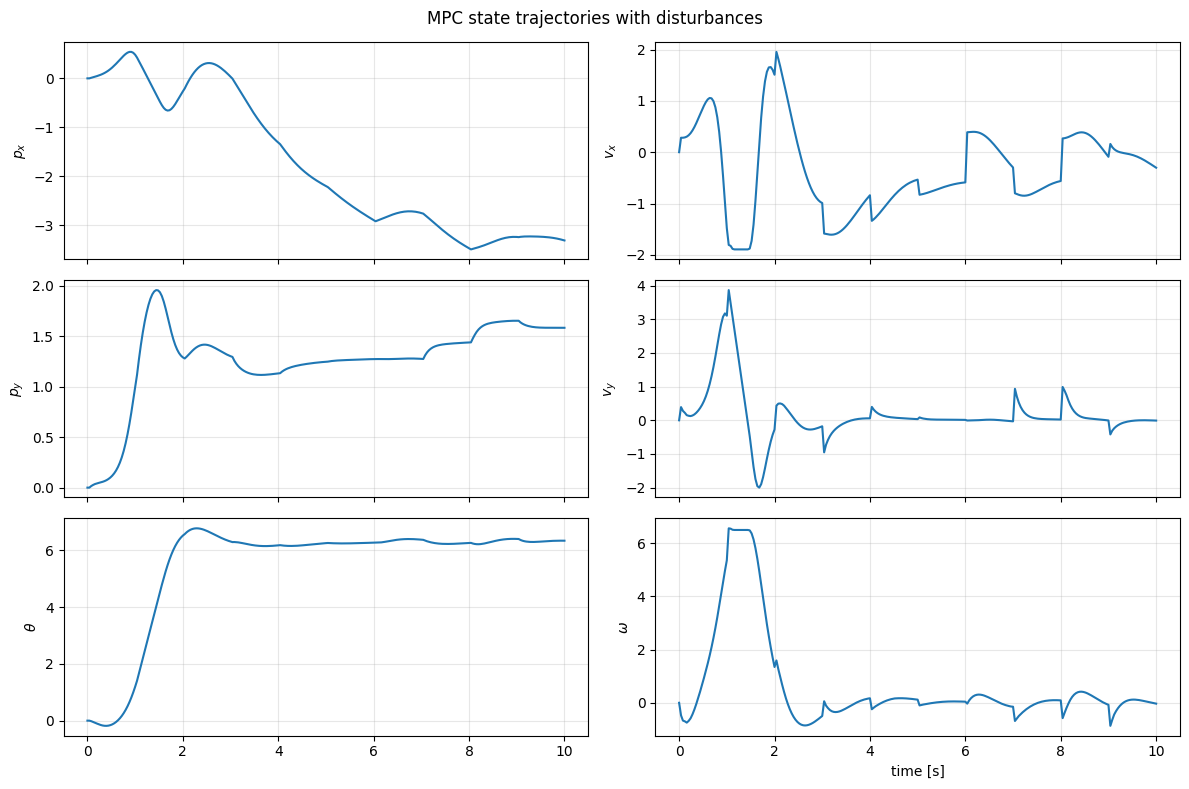

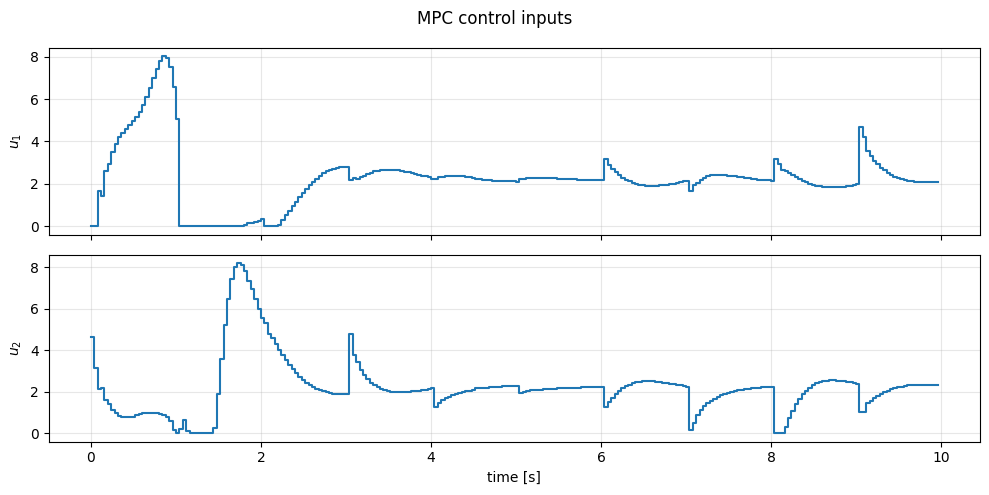

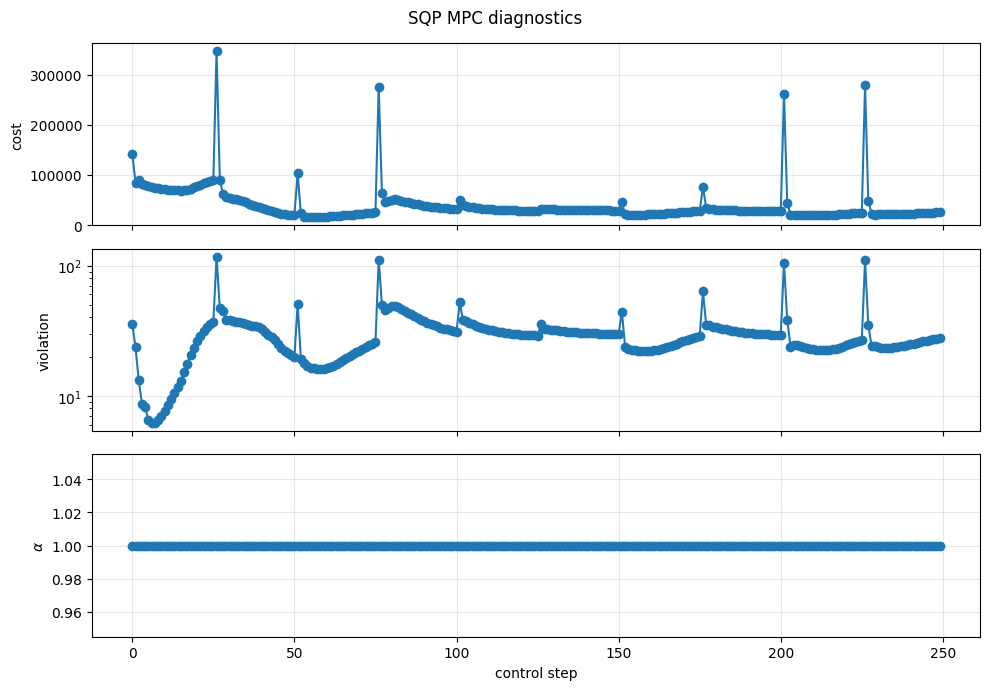

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import quadrotor
# from proj1_traj_optim import DIM_X, build_default_options, SQPMPC

# --- MPC setup ---
mpc_horizon = 45                              # ~2.0 s prediction window for full loop
mpc_opts = build_default_options(mpc_horizon)
mpc = SQPMPC(mpc_opts, debug=True)

x_init = np.zeros(DIM_X)
mpc.reset(x_init)                             # full solve for the initial warm start

steps = int(10.0 / quadrotor.DT)              # 2-second simulation for one loop

def controller(x, t):
    return mpc.control(x, t)

time, states, controls = quadrotor.simulate(
    x_init, controller, steps, disturbance=True
)

# --- state plots ---
labels_state = ["$p_x$", "$v_x$", "$p_y$", "$v_y$", "$\\theta$", "$\\omega$"]
t_grid = time
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.plot(t_grid, states[i, :], label=labels_state[i])
    ax.set_ylabel(labels_state[i])
    ax.grid(alpha=0.3)
axes[-1].set_xlabel("time [s]")
fig.suptitle("MPC state trajectories with disturbances")
plt.tight_layout()

# --- control plots ---
labels_u = ["$u_1$", "$u_2$"]
t_u = time[:-1]
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
for i, ax in enumerate(axes):
    ax.step(t_u, controls[i, :], where="post")
    ax.set_ylabel(labels_u[i])
    ax.grid(alpha=0.3)
axes[-1].set_xlabel("time [s]")
fig.suptitle("MPC control inputs")
plt.tight_layout()

mpc_entries = [entry for entry in mpc.info_history if "time" in entry]

if mpc_entries:
    iters = [entry["time"] for entry in mpc_entries]
    costs = [entry["cost"] for entry in mpc_entries]
    violations = [entry["violation"] for entry in mpc_entries]
    alphas = [entry["alpha"] for entry in mpc_entries]

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
    axes[0].plot(iters, costs, marker="o")
    axes[0].set_ylabel("cost")
    axes[0].grid(alpha=0.3)

    axes[1].plot(iters, violations, marker="o")
    axes[1].set_ylabel("violation")
    axes[1].set_yscale("log")
    axes[1].grid(alpha=0.3)

    axes[2].plot(iters, alphas, marker="o")
    axes[2].set_ylabel("$\\alpha$")
    axes[2].set_xlabel("control step")
    axes[2].grid(alpha=0.3)

    fig.suptitle("SQP MPC diagnostics")
    plt.tight_layout()
else:
    print("No MPC control iterations found in history (only warm-start iterations)")

quadrotor.animate_robot(states, controls)
